## Normalizing Flows - Exercise 6.
### Daniel Aibinder 318239639, Yonathan Dovgolevsky 327709648

In [1]:
## Standard libraries
import os
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/tutorial12"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

C:\Users\Danny\AppData\Local\Temp\ipykernel_15268\3028478413.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


Using device cuda:0


<Figure size 640x480 with 0 Axes>

In [2]:
def add_noise(sample):
    sample = (sample * 255).to(torch.float) # Convert to float and scale to [0, 255]
    noise = torch.rand_like(sample) # Uniform noise in [0, 1]
    noisy_sample = sample + noise
    noisy_sample = noisy_sample / 255.0 # Scale back to [0, 1]
    noisy_sample = torch.clamp(noisy_sample, 0, 1) # Ensure that the values are still in [0, 1]
    return noisy_sample

def flatten_image(image):
    return image.view(-1)

# Transformations: Convert to tensor, add noise and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    add_noise,
    flatten_image
])


# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False)

Global seed set to 42


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


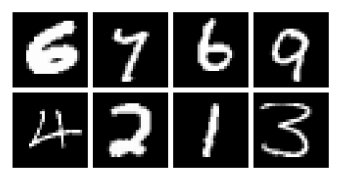

In [3]:
def show_imgs(imgs):
    imgs = [img.view(1, 28, 28) for img in imgs] #unflatten images
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.BatchNorm1d(input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim // 4 ),
            nn.BatchNorm1d(input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4 , input_dim // 4 ),
            nn.BatchNorm1d(input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4 , input_dim // 2 ),
            nn.BatchNorm1d(input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2 , input_dim)
        )
        # self.layers = nn.Sequential(
        #     nn.Linear(input_dim, input_dim * 2 ),
        #     nn.BatchNorm1d(input_dim * 2),
        #     nn.ReLU(),
        #     nn.Linear(input_dim * 2 , input_dim * 2 ),
        #     nn.BatchNorm1d(input_dim * 2 ),
        #     nn.ReLU(),
        #     nn.Linear(input_dim * 2  , input_dim * 2 ),
        #     nn.BatchNorm1d(input_dim * 2 ),
        #     nn.ReLU(),
        #     nn.Linear(input_dim * 2  , input_dim * 2 ),
        #     nn.BatchNorm1d(input_dim * 2 ),
        #     nn.ReLU(),
        #     nn.Linear(input_dim * 2  , input_dim)
        # )


    def forward(self, x):
        self.to(x.device)
        return self.layers(x)

class NormalizingFlowLayer2(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.mlp = MLP(input_dim // 2)
        self.scale = nn.Parameter(torch.randn(input_dim, device=device) * 0.01).to(device)    
        
    def forward(self, x, alternate, inverse = False):
        if not inverse:
            x1, x2 = torch.chunk(x, 2, dim=1)
            if alternate:
                x2 = x2 + self.mlp(x1)
            else:
                x1 = x1 + self.mlp(x2)
            x = torch.cat([x1, x2], dim=1)
            x = x * torch.exp(self.scale)
            logdet = torch.sum(self.scale, dim=-1)
        else:
            x = x * torch.exp(-self.scale.to(device))
            x1, x2 = torch.chunk(x, 2, dim=1)
            if alternate:
                x2 = x2 - self.mlp(x1)
            else:
                x1 = x1 - self.mlp(x2)
            x = torch.cat([x1, x2], dim=1)
            logdet = -torch.sum(self.scale, dim=-1)
        return x, logdet
    
        
class NormalizingFlowModel2(pl.LightningModule):
    def __init__(self,input_dim, num_flows):
        super().__init__()
        self.input_dim = input_dim
        self.num_flows = num_flows
        self.transforms = nn.ModuleList([NormalizingFlowLayer2(input_dim) for _ in range(num_flows)])

    def forward(self, x):
        logdet = torch.zeros(x.shape[0], device=x.device)
        alternate = False
        for transform in self.transforms:
            x, ld = transform(x, alternate)
            logdet += ld
            alternate = not alternate
        return x, logdet
    
    def inverse(self, x):
        logdet = torch.zeros(x.shape[0], device=x.device)
        alternate = True
        for transform in reversed(self.transforms):
            x, ld = transform(x, alternate, inverse=True)
            logdet += ld
            alternate = not alternate
        return x, logdet
    
    def calc_likelihood(self, x):
        z, logdet = self.forward(x)
        logPz = -0.5 * torch.sum(z**2, dim=1) - 0.5 * self.input_dim * math.log(2 * math.pi)

        # log_det = torch.mean(log_det)
        # log2pi = torch.log(torch.tensor(2*np.pi))
        # norm_factor = - 0.5  * 28*28 * log2pi
        # logPz = torch.mean(-0.5 * torch.pow(z,2).sum(1)) + norm_factor # (-1/2) ||z-mu||^2
        return logPz + logdet
    
    @torch.no_grad()
    def sample(self, num_samples):
        z = torch.randn(num_samples, self.input_dim, device=device)
        x,_ = self.inverse(z)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, _ = batch
        log_likelihood = self.calc_likelihood(x).mean()
        loss = -log_likelihood
        self.log('train_log_likelihood', log_likelihood)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, _ = batch
        log_likelihood = self.calc_likelihood(x).mean()
        loss = -log_likelihood
        self.log('val_log_likelihood', log_likelihood)
        return loss

    def test_step(self, batch, batch_idx):
        x, _ = batch
        log_likelihood = self.calc_likelihood(x).mean()
        loss = -log_likelihood
        self.log('test_log_likelihood', log_likelihood)
        return loss


In [5]:
# class MLP(nn.Module):
#     def __init__(self, input_dim):
#         super(MLP, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_dim, input_dim * 4),
#             nn.LeakyReLU(),
#             nn.Linear(input_dim * 4, input_dim * 4),
#             nn.LeakyReLU(),
#             nn.Linear(input_dim * 4, input_dim * 4),
#             nn.LeakyReLU(),
#             nn.Linear(input_dim * 4, input_dim * 4),
#             nn.LeakyReLU(),
#             nn.Linear(input_dim * 4 , input_dim)
#         )

#     def forward(self, x):
#         self.to(x.device)
#         return self.layers(x)

# class NormalizingFlowLayer(nn.Module):
#     def __init__(self, input_dim):
#         super(NormalizingFlowLayer, self).__init__()
#         self.input_dim = input_dim
#         self.scale = nn.Parameter(torch.zeros(input_dim))
#         self.mlp = MLP(input_dim)
    
#     def forward(self, x1, x2):
#         s = self.mlp(x1)
#         s = torch.tanh(s/self.scale.exp()) * self.scale.exp()
#         z1 = x1 * torch.exp(s)
#         z = torch.cat([z1, x2], dim=1)
#         log_det_jacobian = s.sum(dim=1)
#         return z, log_det_jacobian
    
#     def inverse(self, z1, z2):
#         self.to(z1.device)
#         s = self.mlp(z1)
#         s = torch.tanh(s/self.scale.exp()) * self.scale.exp()
#         x1 = z1 * torch.exp(-s)
#         x = torch.cat([x1, z2], dim=1)
#         return x


# class NormalizingFlowModel(pl.LightningModule):
     
#     def __init__(self, input_dim, num_flows):
#         super().__init__()
#         self.save_hyperparameters()
#         self.input_dim = input_dim
#         self.flows = nn.ModuleList([NormalizingFlowLayer(input_dim // 2) for _ in range(num_flows)])
#         self.prior = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(input_dim,device=device), torch.eye(input_dim, device=device))

    
#     def forward(self, x):
#         log_det_jacobian = torch.zeros(x.size(0), device=x.device)
#         alternate = False
#         for flow in self.flows:
#             x1, x2 = x.chunk(2, dim=1)
#             if alternate:
#                 x1, x2 = x2, x1
#             x, ldj = flow(x1, x2)
#             log_det_jacobian += ldj
#             alternate = not alternate
#         return x, log_det_jacobian
    
#     def inverse(self, z):
#         alternate = False
#         for flow in reversed(self.flows):
#             z1, z2 = z.chunk(2, dim=1)
#             if alternate:
#                 z1, z2 = z2, z1
#             z = flow.inverse(z1, z2)
#             alternate = not alternate
#         return z
    
#     def calc_likelihood(self, x):
#         z, log_det_jacobian = self.forward(x)
#         log_pz = self.prior.log_prob(z)
#         #prior_ll = -0.5 * torch.sum(z**2 + np.log(2 * np.pi), dim=-1)
#         return log_pz + log_det_jacobian

#     @torch.no_grad()
#     def sample(self, num_samples):
#         z = self.prior.sample((num_samples,)).to(device)
#         x = self.inverse(z)
#         return x

#     def configure_optimizers(self):
#         optimizer = optim.Adam(self.parameters(), lr=1e-3)
#         scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
#         return [optimizer], [scheduler]

#     def training_step(self, batch, batch_idx):
#         x, _ = batch
#         log_likelihood = self.calc_likelihood(x).mean()
#         loss = -log_likelihood
#         self.log('train_log_likelihood', log_likelihood)
#         return loss
    
#     def validation_step(self, batch, batch_idx):
#         x, _ = batch
#         log_likelihood = self.calc_likelihood(x).mean()
#         loss = -log_likelihood
#         self.log('val_log_likelihood', log_likelihood)
#         return loss

#     def test_step(self, batch, batch_idx):
#         x, _ = batch
#         log_likelihood = self.calc_likelihood(x).mean()
#         loss = -log_likelihood
#         self.log('test_log_likelihood', log_likelihood)
#         return loss



In [6]:
def train_model(use_pretrained = False, pretrained_path = "", **kwargs):
    logger = TensorBoardLogger("tb_logs", name="Flows-ex6")
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "Flows-ex6"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         logger = logger,
                         max_epochs=150,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_log_likelihood"),
                                    LearningRateMonitor("epoch")])
    result = None

    # Check whether pretrained model exists. If yes, load it and skip training
    if os.path.isfile(pretrained_path) and use_pretrained:
        print("Found pretrained model, loading...")
        model = NormalizingFlowModel2.load_from_checkpoint(pretrained_path, **kwargs)
        ckpt = torch.load(pretrained_path, map_location=device)
        result = ckpt.get("result", None)
    else:
        model = NormalizingFlowModel2(**kwargs)
        trainer.fit(model, train_loader, val_loader)
    model = model.to(device)

    if result is None:
        # Test best model on validation and test set
        val_result = trainer.test(model, val_loader, verbose=False)
        test_result = trainer.test(model, test_loader, verbose=False)
        result = {"test": test_result, "val": val_result}
    return model, result

In [7]:
#All graphs taken from tensorboard

# %load_ext tensorboard
# %tensorboard --logdir tb_logs

In [8]:
# QUESTION 1 TRAIN
pretrained_path = "tb_logs//Flows-ex6//q1//checkpoints//epoch=0-step=390.ckpt"
model, result = train_model(input_dim = 28*28, num_flows = 4, use_pretrained=False, pretrained_path=pretrained_path)
test_res = result["test"][0]
print("test_log_likelihood: %4.3f" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_log_likelihood"]))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | transforms | ModuleList | 818 K 
------------------------------------------
818 K     Trainable params
0         Non-trainable params
818 K     Total params
3.274     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

test_log_likelihood: 1491.333


## Results
<!-- <img src="https://raw.githubusercontent.com/daiyral/ex5/main/plots/q1/train_elbo.png" alt="Training Loss (Non-Causal)" width="1000"/> -->

Global seed set to 2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


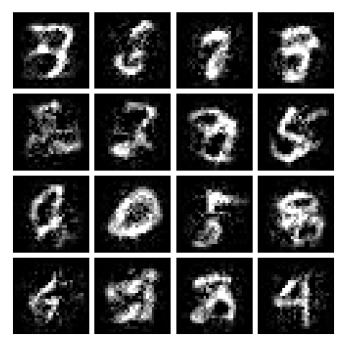

In [10]:
pl.seed_everything(2)
samples = model.sample(num_samples=16)
show_imgs(samples.cpu())

In [ ]:
def q2(i, j):
    im1, im2 = train_set[i][0], train_set[j][0]
    show_imgs([im1, im2])
    (mu1, log_variance1), (mu2, log_variance2) = model.encoder(im1.unsqueeze(1)), model.encoder(im2.unsqueeze(1))
    for i in range(0, 10):
        mu, log_variance = mu1 * (1 - i/10) + mu2 * i/10, log_variance1 * (1 - i/10) + log_variance2 * i/10
        z = model.latent_sample(mu.unsqueeze(0), log_variance.unsqueeze(0))
        reconstructed = model.decoder(z)
        show_imgs(reconstructed.cpu().detach())
q2(1, 2)
q2(2, 3)
q2(5, 6)